# Network Model - Analysis

In [1]:
# Libraries
import numpy as np
import pandas as pd
import igraph as ig
import networkx as nx
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from auxiliar_funcs import *
import matplotlib.pyplot as plt
#import powerlaw as plaw
from collections import Counter
from math import log2, ceil

### Load Data

In [2]:
# Re-order columns by user attributes and resources attributes
user_attr = ['role', 'specialty', 'team', 'uward', 'agentfor']
rsrc_attr = ['type', 'patient', 'treatingteam', 'oward', 'author', 'topic']
print("# User attr:", len(user_attr))
print("# Rsrc attr:", len(rsrc_attr))
print()

##### Load positive access log. #####
url_file = "../00-Data/hc-positive.csv"
df = pd.read_csv(url_file)
df = df[df.columns[:-1]].drop_duplicates()
print("***** POSITIVE HC *****")
print("Columns: ", df.columns)
print("Length: ", len(df))
print(df.info())
print(df.head(5))
print(); print()

##### Load positive access log. #####
url_file = "../00-Data/hc-negative.csv"
df_neg = pd.read_csv(url_file)
df_neg = df_neg[df_neg.columns[:-2]].drop_duplicates()
df_neg = df_neg.replace("?", "none")
df_neg["action"] = 0
print("***** NEGATIVE HC *****")
print("Columns: ", df_neg.columns)
print("Length: ", len(df_neg))
print(df_neg.info())
print(df_neg.head(5))
print(); print()

##### Concatenar solicitudes + y - #####
df_total = pd.concat([df, df_neg])
print("Columns: ", df_total.columns)
print("Length: ", len(df_total))
print()

##### Calcular porcentaje de solicitudes + y - #####
print("% Solicitudes (+): {:.2f}".format((len(df)/len(df_total))*100))
print("% Solicitudes (-): {:.2f}".format((len(df_neg)/len(df_total))*100))
print(); print()

# Cross-Validation
k = 10
test_size = 0.2
kfold = StratifiedShuffleSplit(n_splits=k, test_size=test_size, random_state=1)

data_partition = kfold.split(df_total, df_total.action)
data_corpus = [] # Lista donde se almacenan los k fols

for train_data, test_data in data_partition:        
    X_train, X_test = df_total.iloc[train_data], df_total.iloc[test_data]
    data_corpus.append([X_train, X_test])

print("Hecho!")
print("- k =",k)
print("- Porcentaje Train-Test:", (1-test_size)*100, "-", test_size*100)

print("|U|:", len(df[user_attr].drop_duplicates()))
print("|R|:", len(df[rsrc_attr].drop_duplicates()))

# User attr: 5
# Rsrc attr: 6

***** POSITIVE HC *****
Columns:  Index(['action', 'role', 'type', 'oward', 'uward', 'team', 'treatingteam',
       'patient', 'author', 'topic', 'specialty', 'agentfor'],
      dtype='object')
Length:  8735
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8735 entries, 0 to 8998
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   action        8735 non-null   int64 
 1   role          8735 non-null   object
 2   type          8735 non-null   object
 3   oward         8735 non-null   object
 4   uward         8735 non-null   object
 5   team          8735 non-null   object
 6   treatingteam  8735 non-null   object
 7   patient       8735 non-null   object
 8   author        8735 non-null   object
 9   topic         8735 non-null   object
 10  specialty     8735 non-null   object
 11  agentfor      8735 non-null   object
dtypes: int64(1), object(11)
memory usage: 887.1+ KB
None
   actio

### Data Pre-processing

In [3]:
id_kfold = 0

df_train_k, df_test_k = data_corpus[id_kfold][0], data_corpus[id_kfold][1]
print("# Solicitudes Train:", len(df_train_k), " %: {:.2f}".format((len(df_train_k)/(len(df_train_k)+len(df_test_k)))*100))
print("# Solicitudes Test:", len(df_test_k), " %: {:.2f}".format((len(df_test_k)/(len(df_train_k)+len(df_test_k)))*100))
print("# Solicitudes:", len(df_train_k)+len(df_test_k))
print()

n_rsrcs = len(df_train_k[rsrc_attr].drop_duplicates())

##### ***** TAREA 1: Tratar valores desconocidos y nulos ***** #####
print("Tarea 1: Tratar valores desconocidos y nulos.")
# Cambiar valores string a numeros
mapping = {"none": 10, "doctor": 11, "nurse": 12} # role
df_train_k["role"] = df_train_k["role"].replace(mapping)
df_test_k["role"] = df_test_k["role"].replace(mapping)

mapping = {"note": 110, "cardiology": 111, "nursing": 112, "oncology": 113, "none": 114} # speacialty
df_train_k["specialty"] = df_train_k["specialty"].replace(mapping)
df_test_k["specialty"] = df_test_k["specialty"].replace(mapping)

mapping = {"oncteam1": 1101, "carteam1": 1111,
           "carteam2": 1121, "oncteam2": 1131, "none": 1141} # tem
df_train_k["team"] = df_train_k["team"].replace(mapping)
df_test_k["team"] = df_test_k["team"].replace(mapping)

mapping = {"carward": 11011, "oncward": 11111, "none": 11211} # uward
df_train_k["uward"] = df_train_k["uward"].replace(mapping)
df_test_k["uward"] = df_test_k["uward"].replace(mapping)

mapping = {"oncpat1": 111011, "carpat1": 111111, # agentfor
           "oncpat2": 111211, "carpat2": 111311, "none": 111411}
df_train_k["agentfor"] = df_train_k["agentfor"].replace(mapping)
df_test_k["agentfor"] = df_test_k["agentfor"].replace(mapping)

mapping = {"hr": 1110111, "hritem": 1111111} # type
df_train_k["type"] = df_train_k["type"].replace(mapping)
df_test_k["type"] = df_test_k["type"].replace(mapping)

mapping = {"oncpat1": 211012, "carpat1": 211112, # patient
           "oncpat2": 211212, "carpat2": 211312, "none": 211412}
df_train_k["patient"] = df_train_k["patient"].replace(mapping)
df_test_k["patient"] = df_test_k["patient"].replace(mapping)

mapping = {"oncteam1": 2102, "carteam1": 2112,
           "carteam2": 2122, "oncteam2": 2132, "none": 2142} # treatingteam
df_train_k["treatingteam"] = df_train_k["treatingteam"].replace(mapping)
df_test_k["treatingteam"] = df_test_k["treatingteam"].replace(mapping)

mapping = {"carward": 21012, "oncward": 21112, "none": 21212} # oward
df_train_k["oward"] = df_train_k["oward"].replace(mapping)
df_test_k["oward"] = df_test_k["oward"].replace(mapping)

mapping = {"note": 210, "cardiology": 211, "nursing": 212, "oncology": 213, "none": 214} # topic
df_train_k["topic"] = df_train_k["topic"].replace(mapping)
df_test_k["topic"] = df_test_k["topic"].replace(mapping)

mapping = {"oncdoc2": 11110111, "carnurse1": 11111111, "oncnurse2": 11112111, # author
           "carnurse2": 11113111, "oncdoc1": 11114111, "oncnurse1": 11115111, "none": 11116111}
df_train_k["author"] = df_train_k["author"].replace(mapping)
df_test_k["author"] = df_test_k["author"].replace(mapping)
print("Tarea 1: Hecha!.")
print()

##### ***** TAREA 2: Convertir valores continuas a categoricos ***** #####
print("Tarea 2: No aplica!.")
print()

##### ***** TAREA 3: Eliminar solicitudes duplicadas ***** #####
##### Dataframe solicitudes positivas y negativas #####
print("Tarea 3: Eliminar solicitudes duplicadas.")
df_train_k_pos = df_train_k[df_train_k.action==1]   # Train Pos
df_train_k_neg = df_train_k[df_train_k.action==0]   # Train Neg
df_test_k_pos = df_test_k[df_test_k.action==1]      # Test Pos
df_test_k_neg = df_test_k[df_test_k.action==0]      # Test Neg
df_train_k_pos = df_train_k_pos[df_train_k_pos.columns[1:]].drop_duplicates()
df_train_k_neg = df_train_k_neg[df_train_k_neg.columns[1:]].drop_duplicates()
df_test_k_pos = df_test_k_pos[df_test_k_pos.columns[1:]].drop_duplicates()
df_test_k_neg = df_test_k_neg[df_test_k_neg.columns[1:]].drop_duplicates()
print()

##### Agregar la columna de usuarios y recursos #####
user_dict = get_user_res(df_train_k_pos, user_attr, True)
res_dict = get_user_res(df_train_k_pos, rsrc_attr, False)
df_train_k_pos = add_col(df_train_k_pos, user_dict, user_attr, "USRID")
df_train_k_pos = add_col(df_train_k_pos, res_dict, rsrc_attr, "RESID")
df_train_k_neg = add_col(df_train_k_neg, user_dict, user_attr, "USRID")
df_train_k_neg = add_col(df_train_k_neg, res_dict, rsrc_attr, "RESID")
df_test_k_pos =  add_col(df_test_k_pos, user_dict, user_attr, "USRID")
df_test_k_pos =  add_col(df_test_k_pos, res_dict, user_attr, "RESID")
df_test_k_neg = add_col(df_test_k_neg, user_dict, user_attr, "USRID")
df_test_k_neg = add_col(df_test_k_neg, res_dict, rsrc_attr, "RESID")

print("# Solicitudes Train (+):", len(df_train_k_pos), " %: {:.2f}".format((len(df_train_k_pos)/len(df_train_k))*100))
print("# Solicitudes Train (-):", len(df_train_k_neg), " %: {:.2f}".format((len(df_train_k_neg)/len(df_train_k))*100))
print("# Solicitudes Test (+):", len(df_test_k_pos), " %: {:.2f}".format((len(df_test_k_pos)/len(df_test_k))*100))
print("# Solicitudes Test (-):", len(df_test_k_neg), " %: {:.2f}".format((len(df_test_k_neg)/len(df_test_k))*100))
print("# Train Users (+): ", len(df_train_k_pos.USRID.drop_duplicates()))
print("# Train Resrc (+): ", len(df_train_k_pos.RESID.drop_duplicates()))
print("# Train Users (-): ", len(df_train_k_neg.USRID.drop_duplicates()))
print("# Train Resrc (-): ", len(df_train_k_neg.RESID.drop_duplicates()))
print("# Test Users (+): ", len(df_test_k_pos.USRID.drop_duplicates()))
print("# Test Resrc (+): ", len(df_test_k_pos.RESID.drop_duplicates()))
print("# Test Users (-): ", len(df_test_k_neg.USRID.drop_duplicates()))
print("# Test Resrc (-): ", len(df_test_k_neg.RESID.drop_duplicates()))

task4 = True
if task4:
    # Filter resources
    n1 = 0
    n2 = 210
    top_list = df_train_k_pos.RESID.value_counts()[:n_rsrcs].index.tolist()
    # Filter the interval between n1 and n2
    top_list = top_list[n1:n2+1]
    print('#Filtered resources:', len(top_list))

    # B_II Data splitting
    boolean_series = df_train_k_pos.RESID.isin(top_list)
    df_train_k_pos = df_train_k_pos[boolean_series]
    bolean_series = df_train_k_neg.RESID.isin(top_list)
    df_train_k_neg = df_train_k_neg[bolean_series]



# Solicitudes Train: 14186  %: 80.00
# Solicitudes Test: 3547  %: 20.00
# Solicitudes: 17733

Tarea 1: Tratar valores desconocidos y nulos.
Tarea 1: Hecha!.

Tarea 2: No aplica!.

Tarea 3: Eliminar solicitudes duplicadas.



/home/daniel/anaconda3/envs/tesis_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/daniel/anaconda3/envs/tesis_env/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/daniel/anaconda3/envs/tesis_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

# Solicitudes Train (+): 6988  %: 49.26
# Solicitudes Train (-): 7197  %: 50.73
# Solicitudes Test (+): 1747  %: 49.25
# Solicitudes Test (-): 1800  %: 50.75
# Train Users (+):  1046
# Train Resrc (+):  2090
# Train Users (-):  1045
# Train Resrc (-):  1239
# Test Users (+):  748
# Test Resrc (+):  1
# Test Users (-):  826
# Test Resrc (-):  407
#Filtered resources: 211


### Network Modelling

In [5]:
def build_network_model(data, usr_id_name, res_id_name, file_path=None):
    """
    Builds the Access Requests Bipartite Network from Access log.

    Args:
        data (pandas dataframe): The Access Log.
        usr_id_name (str): The name of the ID users column in the Access Log
        res_id_name (str): The name of the ID resources column in the Access Log
    
    Returns:
        Graph (iGraph): The Access Requests Bipartite Network.

    Raises:
        TypeError: If a network is not Bipartite.
    """
    
    list_of_edges = []
    bi_network = nx.Graph() # NetworkX Graph object

    for usr_idx, rsr_idx in data[[usr_id_name, res_id_name]].values:
        list_of_edges.append((int(usr_idx), int(rsr_idx))) # Tuple of edges
    bi_network.add_edges_from(list_of_edges) # Build Network with edges

    # Change networkX object to iGraph object
    bi_network = ig.Graph.from_networkx(bi_network)
    bi_network.vs['name'] = bi_network.vs["_nx_name"] # Clean name column
    del bi_network.vs["_nx_name"] # Remove uncleaned name column

    print(bi_network.summary())
    print(bi_network.vs())

    if not bi_network.is_bipartite():
        raise TypeError("The ARBN is not bipartite")

    ### Add type of node (user or resource)
    list_of_resources_in_data = list(data[res_id_name])
    list_node_type = []
    for node in bi_network.vs():
        if node['name'] in list_of_resources_in_data:
            list_node_type.append(1) # A resource
        else:
            list_node_type.append(0) # An user
    bi_network.vs["typen"] = list_node_type
    ### End node type

    if not file_path == None: # Create a file
        ig.write(bi_network, file_path)

    print("ARBN builded!")
    print(bi_network.summary())
    print("|U-Nodes| =", len(bi_network.vs.select(typen=0)))
    print("|R-Nodes| =", len(bi_network.vs.select(typen=1)))

    return bi_network

In [6]:
bip_network = build_network_model(df_train_k_pos, 'USRID', 'RESID')

IGRAPH UN-- 823 2340 -- 
+ attr: name (v)
ARBN builded!
IGRAPH UN-- 823 2340 -- 
+ attr: name (v), typen (v)
|U-Nodes| = 612
|R-Nodes| = 211


### User network

In [7]:
def get_edge_weight(i_node, j_node):
    """
    Compute the weight of an edge between i and j nodes.

    Args:
        i_node (networkX node): i node.
        j_node (networkX node): j node.
    
    Returns:
        weight (float): The weight between nodes.

    Raises:
        TypeError: if there are not an intersection
    """
    neighs_i = set(i_node.neighbors())
    neighs_j = set(j_node.neighbors())

    insersection_neighbors = neighs_i.intersection(neighs_j)
    
    weight = (len(insersection_neighbors)*len(insersection_neighbors)) / (len(neighs_i)*len(neighs_j))

    return weight


def bipartite_projection(biparte_network, node_type=0):
    """
    Generate a monopartite network from bipartite network.

    Parameters:
        bipartite_network (igraph Graph): The bipartie network.
        node_type (int): The set of nodes of the monopartite network.

    Returns:
        Graph (iGraph): The monopartite (projected) network.

    Raises:
        Some
    """

    #Check if the bipartite network is a bipartite network:
    if not biparte_network.is_bipartite():
        raise TypeError("The ARBN is not bipartite")

    # networkX object (more easy to buil)
    g = nx.Graph()

    # All opposite node set
    opposite_nodes = biparte_network.vs.select(typen=1)

    # Check for every node the same type
    for X_node in opposite_nodes:
        # Select all neighbors of the X_node
        neighbordhood = X_node.neighbors()

        for Y_node_i in neighbordhood:
            for Y_node_j in neighbordhood:
                # Ceck if both nodes are the same
                if Y_node_i['name'] != Y_node_j['name']:
                    # If there is no an edge generate
                    if not g.has_edge(Y_node_i['name'], Y_node_j['name']):
                        weight_ = get_edge_weight(Y_node_i, Y_node_j)
                        #print("Peso: ", Y_node_i['name'], "-", Y_node_j['name'], " => ", weight_)
                        g.add_edge(Y_node_i["name"], Y_node_j["name"],
                                   weight=weight_)                                 

    # Convert from networkX graph to igraph graph
    g = ig.Graph.from_networkx(g)
    g.vs["name"] = g.vs["_nx_name"]
    del g.vs["_nx_name"]
    
    return g


In [8]:
user_network = bipartite_projection(bip_network, 0)
print(user_network.summary())
# ig.write(user_network, "graphs/amz_user_network.gml")

IGRAPH UNW- 612 14863 -- 
+ attr: name (v), weight (e)


### Network Analysis

In [9]:
# Add features
user_data_attrs = df_train_k_pos[user_attr+["USRID"]].drop_duplicates()
#user_data_attrs[user_data_attrs.USRID == 101]
role_attr = []
specialty_attr = []
team_attr = []
uward_attr = []
agentfor_attr = []
for user in user_network.vs():
    user_row = user_data_attrs[user_data_attrs.USRID == user['name']]    
    role_attr.append(user_row['role'].values[0])
    specialty_attr.append(user_row['specialty'].values[0])
    team_attr.append(user_row['team'].values[0])
    uward_attr.append(user_row['uward'].values[0])
    agentfor_attr.append(user_row['agentfor'].values[0])
    
user_network.vs['role'] = role_attr
user_network.vs['specialty'] = specialty_attr
user_network.vs['team'] = team_attr
user_network.vs['uward'] = uward_attr
user_network.vs['agentfor'] = agentfor_attr
user_network.summary()

'IGRAPH UNW- 612 14863 -- \n+ attr: agentfor (v), name (v), role (v), specialty (v), team (v), uward (v), weight (e)'

In [10]:
density = user_network.density()
print("Density:", "{:.4f}".format(density))

avg_degree = sum(user_network.degree()) / user_network.vcount()
print("Avg. degree", "{:.4f}".format(avg_degree))

components = user_network.components()
print("Connected Components:", len(components))

cc = user_network.transitivity_avglocal_undirected()
print("Clustering Coefficient:", "{:.4f}".format(cc))

L = user_network.average_path_length()
print("Average Path Length :", "{:.4f}".format(L))

Density: 0.0795
Avg. degree 48.5719
Connected Components: 1
Clustering Coefficient: 0.6317
Average Path Length : 2.3571


In [12]:
def calculate_log_binning(degrees_list, n_bins):
    """
    Compute the log-binning y-values.
    """
    current_sum = 0
    previous_k = 0
    y_values_log_bin_list = []
    x_values = []

    for i in range(1, n_bins):
        x_values.append(previous_k)
        current_k = 2 ** (i)
        current_sum = current_sum + current_k
        temp_y_value = sum(degrees_list[previous_k:current_k])
        temp_y_value = temp_y_value / (current_k-previous_k)
        y_values_log_bin_list.append(temp_y_value)
        previous_k = current_k

        if current_sum > len(degrees_list):
            x_values.append(previous_k)
            temp_y_value = sum(degrees_list[previous_k:len(degrees_list)])
            temp_y_value = temp_y_value / (len(degrees_list)-previous_k)
            y_values_log_bin_list.append(temp_y_value)            
            break

    return x_values, y_values_log_bin_list

214


<Figure size 432x288 with 0 Axes>

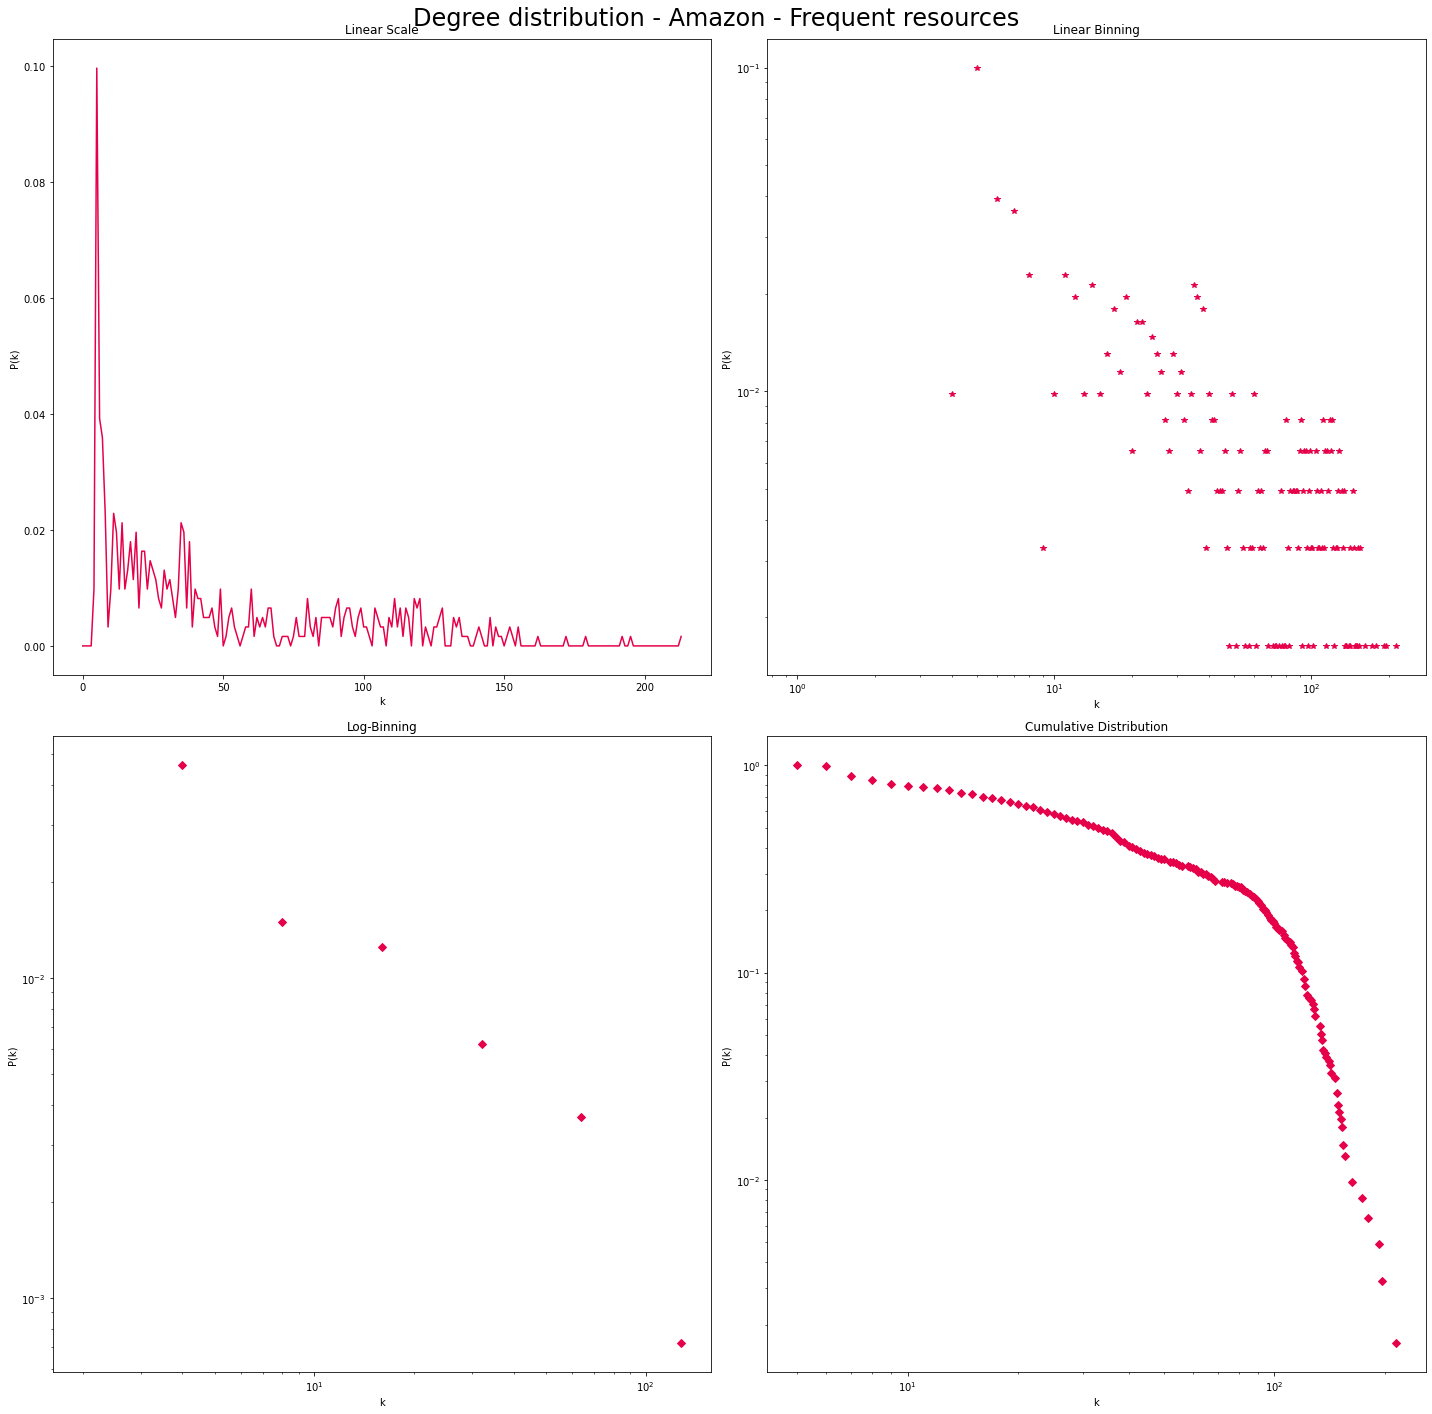

In [13]:
max_degree = max(user_network.degree())
print(max_degree)

# Crear una lista donde se almacena
degree_list = np.zeros(max_degree, dtype=int)

for node in user_network.vs():    
    degree_list[node.degree()-1] = (degree_list[node.degree()-1] + 1)

degree_list = degree_list / user_network.vcount()

plt.clf()
fig, axs = plt.subplots(2, 2, figsize=(20,20))

# LINEAR SCALE
axs[0, 0].set_title('Linear Scale')
axs[0, 0].plot(degree_list, color='#e60049')
axs[0, 0].set(ylabel='P(k)', xlabel='k')

# LINEAR BINNING
axs[0, 1].set_title('Linear Binning')
axs[0, 1].plot(range(max_degree), degree_list, color="#e60049", marker='*', ls='None')
axs[0, 1].loglog()
axs[0, 1].set(ylabel='P(k)', xlabel='k')

# LOG-BINNING
axs[1, 0].set_title('Log-Binning')
n_log_bin = ceil(log2(max(user_network.degree())))
x_values, y_values = calculate_log_binning(degree_list, n_log_bin)
axs[1, 0].plot(x_values, y_values, color='#e60049', marker="D", ls='None')
axs[1, 0].loglog()
axs[1, 0].set(ylabel='P(k)', xlabel='k')

# COMULATIVE
axs[1, 1].set_title("Cumulative Distribution")
degree_sequence = sorted([d for d in user_network.degree()], reverse=True)  # degree sequence
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
cs = np.cumsum(np.array(cnt)/user_network.vcount())
axs[1, 1].loglog(deg, cs, color='#e60049', marker="D", ls='None')
axs[1, 1].set(ylabel='P(k)', xlabel='k')

fig.suptitle("Degree distribution - Amazon - Frequent resources", fontsize=24)
fig.tight_layout()
plt.show()

### Weighted distribution

1000


<Figure size 432x288 with 0 Axes>

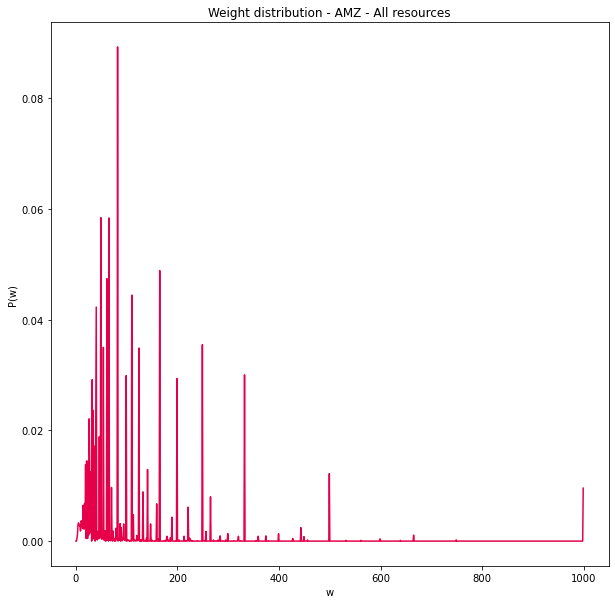

In [15]:
arreglo_test = (np.array(user_network.es['weight'])*1000).astype(int)
max_peso = max(arreglo_test)
print(max_peso)

# Crear una lista donde se almacena
arreglo_test_ = np.zeros(max_peso, dtype=int)

for node in arreglo_test:
    arreglo_test_[node-1] = (arreglo_test_[node-1] + 1)

arreglo_test_ = arreglo_test_ / user_network.ecount()

plt.clf()
plt.figure(figsize=(10,10))
plt.plot(arreglo_test_, color="#e60049")
plt.title("Weight distribution - AMZ - All resources")
plt.xlabel("w")
plt.ylabel("P(w)")
#plt.loglog()
plt.show()

In [21]:
user_network_test = user_network.copy()
user_network_test.es.select(weight_lt=0.4).delete()

In [ ]:
density = user_network_test.density()
print("Density:", density)

avg_degree = sum(user_network_test.degree()) / user_network_test.vcount()
print("Avg. degree", avg_degree)

components = user_network_test.components()
print("Connected Components:", len(components))

### Calculete changes of densities

In [32]:
densitites_list = [user_network.density()] # Store all densities values
thresholds_list = np.linspace(0, 1, num=11)[1:-1] # nine values

for thrs in thresholds_list:
    current_user_net = user_network.copy() # Create a copy of user network
    
    # Remove edges less than current threshold
    current_user_net.es.select(weight_lt=thrs).delete()
    
    current_density = current_user_net.density() # Compute density
    
    # Store current density in the density list
    densitites_list.append(current_density)

# Show densities
print(densitites_list)

[0.022874443231497874, 0.009990839019907624, 0.005340227964554199, 0.003177833267323172, 0.0022572399424410318, 0.002229144219662889, 0.0008576589058590997, 0.0008370455176734518, 0.0008365427521079481, 0.0008364540287728594]


<Figure size 432x288 with 0 Axes>

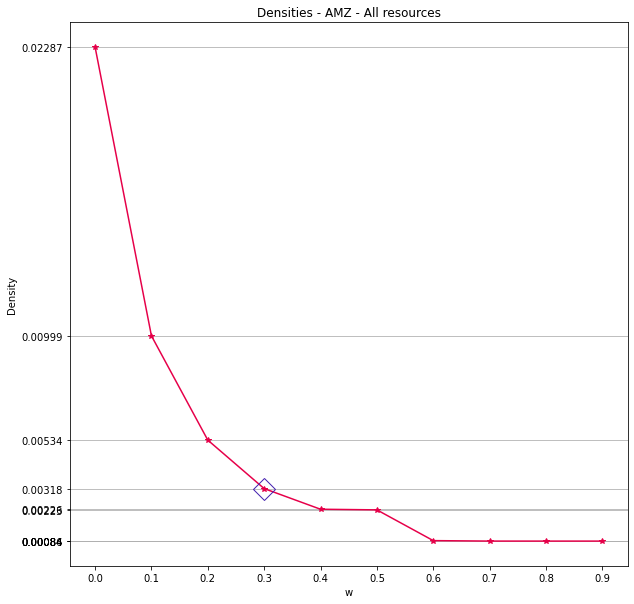

In [61]:
plt.clf()
plt.figure(figsize=(10,10))
plt.plot([0]+list(thresholds_list), densitites_list, color="#e60049", marker='*')
plt.title("Densities - AMZ - All resources")
plt.xlabel("w")
plt.xticks([0]+list(thresholds_list))
plt.ylabel("Density")
plt.yticks(densitites_list)
plt.grid(axis='y')
plt.plot(0.3, densitites_list[3], marker="D", markersize=15, fillstyle='none', color="#4421af")
#plt.loglog()
plt.show()

### Components Analysis

In [16]:
# Shows the size counter of the components
dict_compoenents = dict(Counter(components.sizes()))
print(dict_compoenents)

{612: 1}


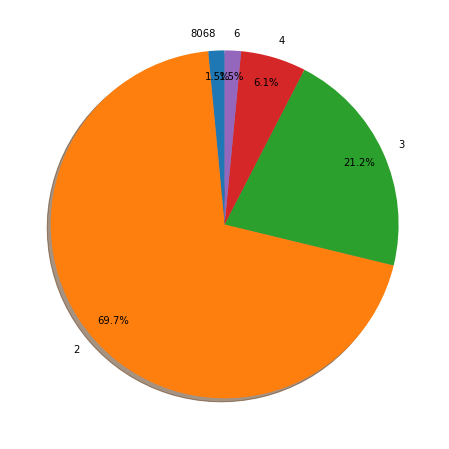

In [56]:
fig, ax = plt.subplots(figsize=(8,))
ax.pie(dict_compoenents.values(), labels=dict_compoenents.keys(), 
       autopct='%1.1f%%', startangle=90, shadow=True, pctdistance=.85)
plt.show()

In [117]:
### Compute the % of nodes in the huge component

# In this case, we have huge component in index=0
huge_component = components.subgraph(0)
print("HugeComp Nodes:", huge_component.vcount())
print("HugeComp Edges:", huge_component.ecount())

# We recall how many user there
n_users_bip = user_network.vcount()
print("|Nodes| =", n_users_bip)

# % of nodes in the huge component
pct_users_huge = huge_component.vcount() / n_users_bip
print("Pct of nodes: {:.2f}%".format(pct_users_huge*100))

# % of links in the huge component 
n_res_bip = user_network.ecount()
print("|Edges| =", n_res_bip)
pct_res_huge = huge_component.ecount() / n_res_bip
print("Pct of edges: {:.2f}%".format(pct_res_huge*100))

HugeComp Nodes: 8068
HugeComp Edges: 773338
|Nodes| = 8224
Pct of nodes: 98.10%
|Edges| = 773453
Pct of edges: 99.99%


In [166]:
### Compute the resources in the components.

counter_res = [] # Save all resources 
counter_res_huge = [] # Save resources in huge component

for compnt in components.subgraphs(): # Omit the huge component
    # Get node users
    users_comp = list(compnt.vs())    
    
    rsrc_in_components = [] # Store "name" attribute of resources

    # Loop over user nodes
    for i_node in users_comp:
        # Search the node in the bipartite network by its name
        i_query = bip_network.vs.find(name=i_node["name"])

        # Get the resources (neighbors) of i_node
        neighs_inodes = bip_network.neighbors(i_query)
        
        # loop over the resources
        for i_rsrc in neighs_inodes:
            # Adding to list
            rsrc_in_components.append(bip_network.vs(i_rsrc)[0]["name"])

    # Remove duplicate values
    rsrc_in_components = list(set(rsrc_in_components))
    
    if len(users_comp) == 8068: # The huge component
        counter_res_huge += rsrc_in_components
    else:
        counter_res += rsrc_in_components # Global resources in small components

# Remove duplicate values
counter_res = list(set(counter_res))
print(len(counter_res), counter_res)

counter_res_huge = list(set(counter_res_huge))
print(len(counter_res_huge), counter_res_huge)

117 [74241, 73741, 36885, 78882, 75815, 89134, 35374, 80947, 73783, 84024, 74297, 79936, 6723, 77390, 34895, 31834, 78429, 78435, 78436, 16997, 36971, 99949, 74874, 100475, 36476, 77946, 74367, 77951, 74369, 27786, 74896, 32401, 74899, 30868, 80021, 79000, 25753, 43165, 27309, 31921, 31922, 74930, 45236, 45237, 73907, 35000, 109753, 71866, 16570, 39612, 31936, 36036, 6855, 716, 79566, 74447, 28370, 42709, 19678, 6878, 74982, 78570, 37115, 27901, 43265, 20744, 39695, 75032, 79640, 78108, 34076, 78111, 40753, 25407, 27970, 26436, 15697, 43860, 56665, 33115, 78178, 37221, 37222, 43879, 26985, 30573, 74610, 73075, 28532, 36724, 74614, 78713, 35716, 28550, 35722, 43915, 45451, 42382, 42383, 37781, 28568, 36772, 75685, 23461, 77225, 44975, 41399, 42945, 70088, 42967, 41433, 32223, 35819, 45044, 74743, 34300, 105470]
5944 [0, 38, 98430, 98431, 98437, 138, 153, 98494, 98500, 199, 203, 216, 32985, 32986, 32987, 32997, 33001, 33002, 233, 237, 98547, 33012, 98552, 256, 33031, 33032, 33033, 33035,

In [168]:
### Number of resources in each component
# Total of resources
total_counter_res = counter_res + counter_res_huge

# Remove duplicate values
total_counter_res = list(set(total_counter_res))

# % of resources in small components of all
pct_res = (len(counter_res) / len(total_counter_res))*100
print("Pct of resources (SMALL): {:.2f}% - ({} / {})".format(pct_res,
                                                             len(counter_res),
                                                             len(total_counter_res)))

# % of resources in small components of all
pct_res = (len(counter_res_huge) / len(total_counter_res))*100
print("Pct of resources (HUGE): {:.2f}% - ({} / {})".format(pct_res, 
                                                            len(counter_res_huge),
                                                            len(total_counter_res)))

Pct of resources (SMALL): 1.93% - (117 / 6061)
Pct of resources (HUGE): 98.07% - (5944 / 6061)


In [171]:
### Importance of resources in each component

dict_freq_res = {} # Save counter access

for i_res in counter_res: # Small components
    # Number of accesss requests in Dataframe
    dict_freq_res[i_res] = len(df_train_k_pos[df_train_k_pos.RESOURCE==i_res])

print("MAX access in a resource (SMALL):", max(dict_freq_res.values()))

for i_res in counter_res_huge: # Small components
    # Number of accesss requests in Dataframe
    dict_freq_res[i_res] = len(df_train_k_pos[df_train_k_pos.RESOURCE==i_res])

print("MAX access in a resource (HUGE):", max(dict_freq_res.values()))

MAX access in a resource (SMALL): 5
MAX access in a resource (HUGE): 671


In [181]:
### Analysis all networks vs huge compoenent

density = user_network.density()
print("Density (ALL):", "{:.4f}".format(density))
density = huge_component.density()
print("Density (HUGE):", "{:.4f}".format(density))

avg_degree = sum(user_network.degree()) / user_network.vcount()
print("Avg. degree (ALL)", "{:.4f}".format(avg_degree))
avg_degree = sum(huge_component.degree()) / huge_component.vcount()
print("Avg. degree (HUGE)", "{:.4f}".format(avg_degree))

components = user_network.components()
print("Connected Components (ALL):", len(components))
components = huge_component.components()
print("Connected Components (HUGE):", len(components))

cc = user_network.transitivity_avglocal_undirected()
print("Clustering Coefficient (ALL):", "{:.4f}".format(cc))
cc = huge_component.transitivity_avglocal_undirected()
print("Clustering Coefficient: (HUGE)", "{:.4f}".format(cc))

L = user_network.average_path_length()
print("Average Path Length (ALL):", "{:.4f}".format(L))
L = huge_component.average_path_length()
print("Average Path Length (HUGE):", "{:.4f}".format(L))

Density (ALL): 0.0229
Density (HUGE): 0.0238
Avg. degree (ALL) 188.0965
Avg. degree (HUGE) 191.7050
Connected Components (ALL): 66
Connected Components (HUGE): 1
Clustering Coefficient (ALL): 0.7931
Clustering Coefficient: (HUGE) 0.7924
Average Path Length (ALL): 2.8750
Average Path Length (HUGE): 2.8750


### Community Analysis

In [17]:
### Community detection algorithm

# Louvain Algorithm
partition = user_network.community_multilevel(weights=user_network.es()["weight"])
print("Modularity: %.4f" % partition.modularity) # Modualarity value

# Add cluster attribute to nodes
user_network.vs["cluster"] = partition.membership

print(user_network.summary())
print(partition.summary())

Modularity: 0.4660
IGRAPH UNW- 612 14863 -- 
+ attr: agentfor (v), cluster (v), name (v), role (v), specialty (v), team (v), uward (v), weight (e)
Clustering with 612 elements and 13 clusters


In [18]:
def agregar_identificador_com(grafo, set_usuarios, id_):
    for user_ in set_usuarios:
        vertice = grafo.vs.find(name=user_)
        vertice["cluster"] = id_

In [19]:
# Se obtienen las comunidades y sub-comunidades
g = user_network

density_threshold = 0.5

n_coms = len(set(g.vs["cluster"]))
count_n_coms = 0 # Contador de número de comunidades detectadas
# Diccionario con las comunidades. Id de la comunidad como key y una lista 
# como value {01: [subgrafo, recursos_list]}
dict_total_coms = {} 
id_comunidad = 0

for idx_comm in range(n_coms): # Recorrer cada comunidad en la red
    subgraph_nodes = g.vs.select(cluster=idx_comm) # Sacamos los nodos con el cluster
    comm_subgraph = subgraph_nodes.subgraph() # Objeto de subgrafo

    # Verificar si la densidad es baja: Si es baja se puede clasificar
    if comm_subgraph.density() < density_threshold:

        # Se realiza nuevamente una partición
        new_partition = comm_subgraph.community_multilevel(
            weights =comm_subgraph.es["weight"] )        

        for sub_com in new_partition.subgraphs(): # Se recorre cada nueva sub comunidad
            # Usuarios en la comunidad
            user_set_comm = sub_com.vs()["name"]   
            # Recursos en la comunidad
            n_res = num_recursos(user_set_comm, bip_network)            
            dict_total_coms[str(count_n_coms)] = [sub_com, n_res]
            agregar_identificador_com(g, user_set_comm, id_comunidad)
            id_comunidad += 1
            count_n_coms += 1
    else:
        user_set_comm = comm_subgraph.vs()["name"]   
        # Recursos en la comunidad
        n_res = num_recursos(user_set_comm, bip_network)            
        dict_total_coms[str(count_n_coms)] = [comm_subgraph, n_res]
        agregar_identificador_com(g, user_set_comm, id_comunidad)
        id_comunidad += 1
        count_n_coms += 1

print("# de Comunidades: ", len(dict_total_coms))

# de Comunidades:  50


In [20]:
### Classify communities
def num_recursos(user_sets, grafo_bip):
    all_recursos = set()
    user_sets = [int(float(i)) for i in user_sets]
    for user in user_sets:
        user_node = grafo_bip.vs.find(name=int(float(user)))
        vecinos_recurso = user_node.neighbors()
        vecinos_recurso = [nodo["name"] for nodo in vecinos_recurso]
        vecinos_recurso = set(vecinos_recurso)    
        all_recursos = all_recursos.union(vecinos_recurso)
    return list(all_recursos)            

def numero_registros2(sub_com, dataf):
    """Retorna los registros en una comunidad."""
    dict_resc = {}
    for node in sub_com.vs():
        recursos = list(dataf[dataf.USRID == float(node["label"])]["RESID"])
        for i in recursos:
            if i in dict_resc.keys():
                dict_resc[i] += 1
            else:
                dict_resc[i] = 1
    
    # Remove low values
    dict_temp = {}
    for item in dict_resc.items():
        if item[1] > 2:
            dict_temp[item[0]] = item[1]
    dict_temp = dict(sorted(dict_temp.items(), key=lambda item: item[1], reverse=True))

    if len(dict_temp) < 1:
        return  len(list(dict_temp.keys()))
    return len(list(dict_temp.keys()))

def numero_registros3(sub_com, dataf):
    """Retorna los registros en una comunidad."""
    dict_resc = {}
    for node in sub_com.vs():
        recursos = list(dataf[dataf.USRID == float(node["label"])]["RESID"])
        for i in recursos:
            if i in dict_resc.keys():
                dict_resc[i] += 1
            else:
                dict_resc[i] = 1
    
    # Remove low values
    dict_temp = {}
    for item in dict_resc.items():
        if item[1] > 2:
            dict_temp[item[0]] = item[1]
    dict_temp = dict(sorted(dict_temp.items(), key=lambda item: item[1], reverse=True))

    if len(dict_temp) < 1:
        return  dict_temp
    # return len(list(dict_temp.keys()))
    return dict_temp


def numero_registros4(sub_com, dataf):
    """Retorna los registros en una comunidad."""
    dict_resc = {}
    for node in sub_com.vs():
        recursos = list(dataf[dataf.USRID == int(node["label"])]["RESID"])
        for i in recursos:
            if i in dict_resc.keys():
                dict_resc[i] += 1
            else:
                dict_resc[i] = 1
    
    # Remove low values
    dict_temp = {}
    for item in dict_resc.items():
        if item[1] > 2:
            dict_temp[item[0]] = item[1]
    dict_temp = dict(sorted(dict_temp.items(), key=lambda item: item[1], reverse=True))

    if len(dict_temp) < 1:
        return  dict_temp
    # return len(list(dict_temp.keys()))
    return dict_temp

def get_users_from_resource_comms(resource_id, community, data):
    """Retorna los usuarios de la comunidad que acceden al conjunto de recursos"""
    users_to_ret = []
    for res in resource_id:
        all_user_in_community = community.vs()["label"] # Extraer usuarios de comunidad
        ## all_user_in_community = [int(item) for item in all_user_in_community] # Convertimos a int
        all_user_in_community = set(all_user_in_community) # Covnertimos a conjunto
        solicitudes_en_data = data[data["RESID"]==res]["USRID"].to_list() # Todos los usuarios que acceden al recurso
        solicitudes_en_data = [str(item)+".0" for item in solicitudes_en_data]
        solicitudes_en_data = set(solicitudes_en_data)
        # print(all_user_in_community)
        # print(solicitudes_en_data)
        users_to_ret = users_to_ret + list(all_user_in_community.intersection(solicitudes_en_data)) # Intersección
    users_to_ret = list(set(users_to_ret))
    return users_to_ret

def remove_equal_rules(rules):
    """ Remove equal rules X -> Y == Y -> X"""
    to_remove = []
    lrules = len(rules)
    for i in range(lrules):
        for j in range(i+1,lrules):
            if rules[i][0] == rules[j][1] and rules[i][1] == rules[j][0]:        
                to_remove.append(rules[i])

    #print(to_remove)
    return to_remove

def remove_equal_rules2(rules):
    """ Remove equal rules X -> Y == Y -> X"""
    to_remove = []
    for rule in rules:
        descri = []
        for ele in rule[0]:
            descri.append(ele)
        for ele in rule[1]:
            descri.append(ele)
        descri.sort()
        if descri in to_remove:
            continue
        else:            
            to_remove.append(descri)

    # Quedarse con la de mayor tamaño
    max_id = 0
    to_ret = None
    for i in to_remove:        
        if len(i) > max_id:            
            max_id = len(i)
            to_ret = i

    return [to_ret]

# Function to check if a value appear in column
def get_attr_name(value, df_):
    """ Return name of the column of the value."""
    cols = df_.columns  
    if value == 10:
            # Buscar el atributo maximo
        max_val = 0
        attr_  = None
        for i in cols:        
            t = len(df_[df_[i]==10])            
            if t > max_val:
                max_val = t
                attr_ = i
        return attr_
    else:
        for i in range(len(cols)):        
            if len(df_[df_[cols[i]]==value]) > 0:
                return df_.columns[i]

def get_attr_val_in_users(users_id, data):
    """Retorna los atributo valor en comun en un conjunto de usuarios."""
    user_convert = [float(n) for n in users_id] # Convertimos a float
    attr_user_ = data[data["USRID"].isin(user_convert)].drop_duplicates() # Seleccionamos usuarios
    attr_user__ = attr_user_[user_attr+["USRID"]].values.tolist() # Seleccionamos attributos de los usuarios
    attr_user_ = attr_user_[user_attr+["USRID"]]
    # print(attr_user_)
    init_Sup = 0.6
    init_Conf = 0.9
    rules = []
    while len(rules) == 0:
        # print("Sup", init_Sup, "  Conf", init_Conf)
        _, rules = apriori(attr_user__, minSup=init_Sup, minConf=init_Conf) # Apply apriori
        init_Sup -= 0.1
        init_Conf -= 0.1
    # print(rules)
    rules = remove_equal_rules2(rules)
    #print("XXX",rules)
    #for r in rules:
    #    print(r)
    
    reglas_karimi = []
    for r in rules:      
        for t in r:                                    
            col = get_attr_name(t, attr_user_)                                                             
            reglas_karimi.append([col, t])

    return reglas_karimi

def get_attr_val_in_users_2(users_id, data):
    """Retorna los atributo valor en comun en un conjunto de usuarios."""
    user_convert = [float(n) for n in users_id] # Convertimos a float
    attr_user_ = data[data["USRID"].isin(user_convert)].drop_duplicates() # Seleccionamos usuarios
    attr_user__ = attr_user_[user_attr].values.tolist() # Seleccionamos attributos de los usuarios
    attr_user_ = attr_user_[user_attr+["USRID"]]
    # print(attr_user_)
    init_Sup = 0.6
    init_Conf = 0.9
    rules = []
    while len(rules) == 0:
        # print("Sup", init_Sup, "  Conf", init_Conf)
        _, rules = apriori(attr_user__, minSup=init_Sup, minConf=init_Conf) # Apply apriori
        init_Sup -= 0.1
        init_Conf -= 0.1
        if init_Sup < 0:
            return attr_user__
    # print(rules)
    rules = remove_equal_rules2(rules)
    #print("XXX",rules)
    #for r in rules:
    #    print(r)
    
    reglas_karimi = []
    for r in rules:      
        for t in r:                                    
            col = get_attr_name(t, attr_user_)                                                             
            reglas_karimi.append([col, t])

    return reglas_karimi

def get_attr_val_in_res(res_ids, data):
    """Retorna los atributo valor en comun en un conjunto de usuarios."""    
    user_convert = [float(n) for n in res_ids] # Convertimos a float
    attr_user_ = data[data["RESID"].isin(user_convert)].drop_duplicates() # Seleccionamos usuarios
    attr_user__ = attr_user_[rsrc_attr].values.tolist() # Seleccionamos attributos de los usuarios
    attr_user_ = attr_user_[rsrc_attr+["RESID"]]
    #print(attr_user_)
    # print(attr_user_)
    init_Sup = 0.6
    init_Conf = 0.9
    rules = []
    while len(rules) == 0:
        # print("Sup", init_Sup, "  Conf", init_Conf)
        _, rules = apriori(attr_user__, minSup=init_Sup, minConf=init_Conf) # Apply apriori
        init_Sup -= 0.1
        init_Conf -= 0.1
    # _, rules = apriori(attr_user__, minSup=0.6, minConf=0.9) # Apply apriori
    rules = remove_equal_rules2(rules)
    #for r in rules:
    #    print(r)
    
    reglas_karimi = []
    for r in rules:      
        for t in r:                                    
            col = get_attr_name(t, attr_user_)                                                             
            reglas_karimi.append([col, t])

    return reglas_karimi

def get_attr_val_in_res_2(res_ids, data):
    """Retorna los atributo valor en comun en un conjunto de usuarios."""    
    user_convert = [float(n) for n in res_ids] # Convertimos a float
    attr_user_ = data[data["RESID"].isin(user_convert)].drop_duplicates() # Seleccionamos usuarios
    attr_user__ = attr_user_[rsrc_attr].values.tolist() # Seleccionamos attributos de los usuarios
    attr_user_ = attr_user_[rsrc_attr+["RESID"]]
    #print(attr_user_)
    # print(attr_user_)
    init_Sup = 0.6
    init_Conf = 0.9
    rules = []
    while len(rules) == 0:
        # print("Sup", init_Sup, "  Conf", init_Conf)
        _, rules = apriori(attr_user__, minSup=init_Sup, minConf=init_Conf) # Apply apriori
        init_Sup -= 0.1
        init_Conf -= 0.1
        if init_Sup < 0:
            return attr_user__
    # _, rules = apriori(attr_user__, minSup=0.6, minConf=0.9) # Apply apriori
    rules = remove_equal_rules2(rules)
    #for r in rules:
    #    print(r)
    
    reglas_karimi = []
    for r in rules:      
        for t in r:                                    
            col = get_attr_name(t, attr_user_)                                                             
            reglas_karimi.append([col, t])

    return reglas_karimi


def podado_recursos(recursos, subgrafo, umbral):
    """Realiza el podado de los recursos que casi no acceden"""
    n_usuarios = subgrafo.vcount()
    to_ret = {}    
    for i in recursos:
        us_temp = recursos[i]
        if (us_temp / n_usuarios) > umbral:
            to_ret[i] = us_temp
    return to_ret

def recurso_significativo(recursos, subgrafo, umbral):
    """Retorna el recurso significativo. 'None' si no hay."""
    n_usuarios = subgrafo.vcount()
    to_ret = {}    
    for i in recursos:
        us_temp = recursos[i]
        if (us_temp / n_usuarios) >= umbral:
            return to_ret[i]
    return None

def extraer_recursos_similares(recursos, data_, umbral):
    """Retorna registros similares como nuevos registros"""

    for atr in rsrc_attr: # Se reccorre los atributos
        for r1 in recursos: # Se recorre los recursos
            for atr2 in rsrc_attr:
                if atr != atr2: # Se cambian los recursos
                    print()


def get_apriori_final(usuarios, recursos, data):
    """Retorna los atributo valor en comun en un conjunto de usuarios."""
    user_convert = [float(n) for n in usuarios] # Convertimos a float
    attr_user_ = data[data["USRID"].isin(user_convert)].drop_duplicates() # Seleccionamos usuarios
    res_convert = [float(n) for n in recursos] # Convertimos a float
    attr_user_ = attr_user_[attr_user_["RESID"].isin(res_convert)].drop_duplicates() # Seleccionamos recursos
    attr_user__ = attr_user_[user_attr+rsrc_attr].values.tolist() # Seleccionamos attributos de los usuarios
    attr_user_ = attr_user_[user_attr+rsrc_attr]
    # print(attr_user_)
    init_Sup = 0.5
    init_Conf = 0.8
    rules = []
    while len(rules) == 0:
        _, rules = apriori(attr_user__, minSup=init_Sup, minConf=init_Conf) # Apply apriori
        init_Sup -= 0.1
        init_Conf -= 0.1
    # print(rules)
    rules = remove_equal_rules2(rules)
    
    reglas_karimi = []
    for r in rules:      
        for t in r:                                    
            col = get_attr_name(t, attr_user_)                                                             
            reglas_karimi.append([col, t])

    return reglas_karimi

def agregar_diccionario(diccionario, recurso, tupla_datos):
    if recurso in diccionario:
        diccionario[recurso].append(tupla_datos)
    else:
        diccionario[recurso] = [tupla_datos]

def agregar_usuario_com(diccio, com_id, usuario):
    if com_id in diccio:
        if not usuario in diccio[com_id]:
            diccio[com_id].append(usuario)
    else:
        
        diccio[com_id] = [usuario]


In [21]:
# Obtener el máximo valor de recursos en el total de comunidades
n_res_in_comms = [len(i[1]) for i in dict_total_coms.values()]
max_n_res = max(n_res_in_comms)
print("Comunidad con # mayor recursos", max_n_res)

# Umbrales para la clasificación de comunidades
big_threshold = int(0.50 * max_n_res)
med_threshold = int(0.25 * max_n_res)
print("Big Threshold: ", big_threshold, " \t\t Med Threshold", med_threshold)

Comunidad con # mayor recursos 98
Big Threshold:  49  		 Med Threshold 24


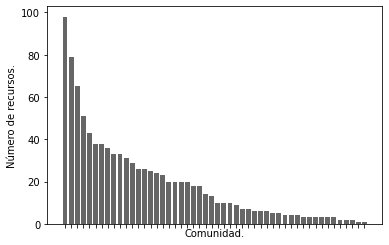

In [22]:
plt.bar(dict_total_coms.keys(), sorted(n_res_in_comms, reverse=True), color='0.40')
plt.ylabel('Número de recursos.')
plt.xlabel('Comunidad.')
plt.tick_params(labelbottom=False)
#plt.savefig('n_recursos_por_comunidad_amz.pdf')

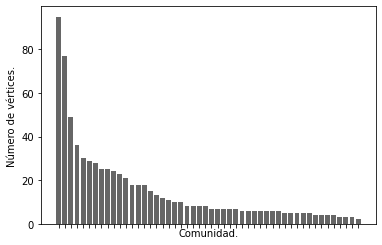

In [23]:
lista_tamano_coms = []
for i in dict_total_coms:
    lista_tamano_coms.append(dict_total_coms[i][0].vcount())
    #print(dict_total_coms[i][0].vcount())
len(lista_tamano_coms)

# plt.figure(figsize=(20,15))
plt.bar(dict_total_coms.keys(), sorted(lista_tamano_coms, reverse=True), color='0.40')
plt.ylabel('Número de vértices.')
plt.xlabel('Comunidad.')
plt.tick_params(labelbottom=False)
#plt.savefig('n_vertices_por_comunidad_amz.pdf')

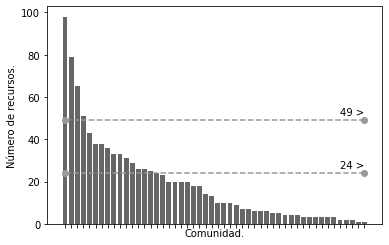

In [24]:
# plt.figure(figsize=(20,15))
plt.bar(dict_total_coms.keys(), sorted(n_res_in_comms, reverse=True), color='0.40')
plt.ylabel('Número de recursos.')
plt.xlabel('Comunidad.')
x, y = [0, len(n_res_in_comms)-1] , [big_threshold, big_threshold]
plt.plot(x, y, marker = 'o', linestyle='--', color="0.6")
plt.text(len(n_res_in_comms)-5, big_threshold+6, '{} >'.format(big_threshold) , ha='left', va= 'top')
x, y = [0, len(n_res_in_comms)-1] , [med_threshold, med_threshold]
plt.plot(x, y, marker = 'o', linestyle='--', color="0.6")
plt.text(len(n_res_in_comms)-5, med_threshold+6, '{} >'.format(med_threshold) , ha='left', va= 'top')
plt.tick_params(labelbottom=False)
#plt.savefig('n_recursos_por_comunidad_amz-corte.pdf')

In [25]:
def agregar_tipo_com(grafo, set_users_, tipo):
    for user_ in set_users_:
        vertice = grafo.vs.find(name=user_)
        vertice["tipoCom"] = tipo

In [26]:
big_comms = [] # Almacenar las comunidades grandes
med_comms = [] # Almacenar las comunidades medianas
sma_comms = [] # Almacenar las comunidades pequeñas
user_network.vs["tipoCom"] = -1


for idx_com, com in enumerate(dict_total_coms.values()):
    if len(com[1]) > big_threshold: # Es comunidad grande
        big_comms.append([idx_com]+com)
        nodos_ = com[0].vs["name"]
        agregar_tipo_com(user_network, nodos_, 0)
    elif len(com[1]) > med_threshold: # Es comunidad mediana
        med_comms.append([idx_com]+com)
        nodos_ = com[0].vs["name"]
        agregar_tipo_com(user_network, nodos_, 1)
    else:
        sma_comms.append([idx_com]+com)
        nodos_ = com[0].vs["name"]
        agregar_tipo_com(user_network, nodos_, 2)

print("# Comunidades:",len(big_comms)+len(med_comms)+len(sma_comms), "==", len(dict_total_coms))
print("Big Comms:", len(big_comms))
print("Med Comms:", len(med_comms))
print("Sma Comms:", len(sma_comms))

# Comunidades: 50 == 50
Big Comms: 4
Med Comms: 11
Sma Comms: 35


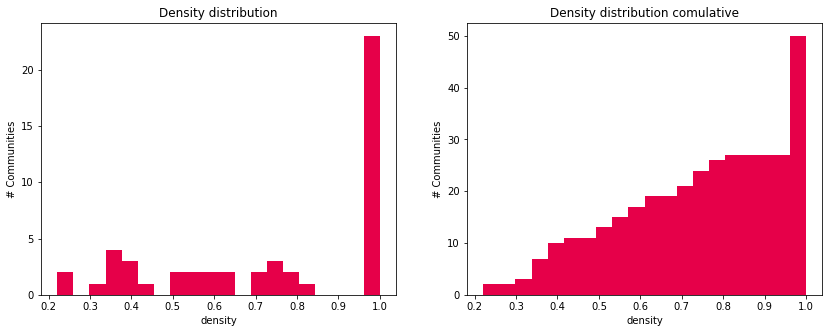

In [27]:
### Density distribution of each community

density_distribution = [] # Store all densities

for comty in sma_comms+med_comms+big_comms: # Loop over all type communities    
    temp_density = comty[1].density() # Graph object [1]
    density_distribution.append(temp_density)

fig, axs = plt.subplots(1, 2, figsize=(14,5))

counts, bins = np.histogram(density_distribution, 20)

# Density distribution
axs[0].set_title('Density distribution')
axs[0].hist(bins[:-1], bins, weights=counts, color="#e60049")
axs[0].set(ylabel='# Communities', xlabel='density')

axs[1].set_title('Density distribution comulative')
axs[1].hist(bins[:-1], bins, weights=counts, color="#e60049", cumulative=True,
            histtype="bar")
axs[1].set(ylabel='# Communities', xlabel='density')

plt.show()


In [28]:
### Resource accessed distribution by communities
# Recorresr todos los recursos y ver los usuarios que acceden al él. Detectar
# de cual tipo de comunidad atrae más usuarios.

all_types_coms = sma_comms + med_comms + big_comms # All types of communitites

 # Store the number of users in each type of community
dict_user_coms = {} # Example -> {id_res: {sma: 40, med: 12, big: 4}, ...}

for rsrc in bip_network.vs.select(typen=1):
    # Get all users "name" which accessed to the rsrc (resource)
    users_name_accessed = [i["name"] for i in rsrc.neighbors()]

    # Counters
    counter_small = 0
    counter_med = 0
    counter_big = 0
    rsr_impor_sma = rsr_impor_med = rsr_impor_big = 0    
    counter_coms = 0
    counter_coms_type_sma = counter_coms_type_med = counter_coms_type_big = 0
    
    # Get all user in small communities
    for comty in sma_comms:
        users_in_com = comty[1].vs["name"]    
        # Intersection of above lists
        intersec_users = set(users_in_com).intersection(set(users_name_accessed))
        if len(intersec_users) > 0:
            counter_small += len(intersec_users)
            rsr_impor_sma += len(intersec_users) / len(users_in_com)
            counter_coms += 1

    if counter_coms > 0:
        rsr_impor_sma = rsr_impor_sma / counter_coms
        counter_coms_type_sma = counter_coms / len(sma_comms)
    else:
        rsr_impor_sma = 0
        counter_coms_type_sma = 0
    counter_coms = 0

    # Get all user in small communities
    for comty in med_comms:
        users_in_com = comty[1].vs["name"]    
        # Intersection of above lists
        intersec_users = set(users_in_com).intersection(set(users_name_accessed))
        if len(intersec_users) > 0:
            counter_med += len(intersec_users)
            rsr_impor_med += len(intersec_users) / len(users_in_com)
            counter_coms += 1
        
    if counter_coms > 0:
        rsr_impor_med = rsr_impor_med / counter_coms
        counter_coms_type_med = counter_coms / len(med_comms)
    else:
        rsr_impor_med = 0
        counter_coms_type_med = 0
    counter_coms = 0

    for comty in big_comms:
        users_in_com = comty[1].vs["name"]    
        # Intersection of above lists
        intersec_users = set(users_in_com).intersection(set(users_name_accessed))
        if len(intersec_users) > 0:
            counter_big += len(intersec_users)
            rsr_impor_big += len(intersec_users) / len(users_in_com)
            counter_coms += 1

    if counter_coms > 0:
        rsr_impor_big = rsr_impor_big / counter_coms
        counter_coms_type_big = counter_coms / len(big_comms)
    else:
        rsr_impor_big = 0
        counter_coms_type_big = 0
    counter_coms = 0

    
    total_accessed = counter_big + counter_small + counter_med
    total_counter_coms = counter_coms_type_sma + counter_coms_type_med + counter_coms_type_big
    total_rsr_impor = rsr_impor_sma + rsr_impor_med + rsr_impor_big
    # Add all counters
    dict_user_coms[rsrc["name"]] = {"sma": counter_small/total_accessed,
                                     "med": counter_med/total_accessed,
                                     "big":counter_big/total_accessed,
                                     "impComSma": counter_coms_type_sma/total_counter_coms,
                                     "impComMed": counter_coms_type_med/total_counter_coms,
                                     "impComBig": counter_coms_type_big/total_counter_coms,
                                     "impsma": rsr_impor_sma/total_rsr_impor,
                                     "impmed": rsr_impor_med/total_rsr_impor,
                                     "impbig": rsr_impor_big/total_rsr_impor}
    
#dict_user_coms

In [31]:
a = pd.DataFrame(dict_user_coms)
a = a.T
a["name"] = range(211)
a = a.sort_values("sma", ascending=False)
a

,sma,med,big,impComSma,impComMed,impComBig,impsma,impmed,impbig,name
1052202,1.0,0.000,0.000,1.0,0.000000,0.000000,1.0,0.000000,0.000000,192
304202,1.0,0.000,0.000,1.0,0.000000,0.000000,1.0,0.000000,0.000000,94
463202,1.0,0.000,0.000,1.0,0.000000,0.000000,1.0,0.000000,0.000000,127
479202,1.0,0.000,0.000,1.0,0.000000,0.000000,1.0,0.000000,0.000000,131
967202,1.0,0.000,0.000,1.0,0.000000,0.000000,1.0,0.000000,0.000000,186
...,...,...,...,...,...,...,...,...,...,...
467202,0.0,0.000,1.000,0.0,0.000000,1.000000,0.0,0.000000,1.000000,129
128202,0.0,0.875,0.125,0.0,0.592593,0.407407,0.0,0.791198,0.208802,44
449202,0.0,0.000,1.000,0.0,0.000000,1.000000,0.0,0.000000,1.000000,126
129202,0.0,0.000,1.000,0.0,0.000000,1.000000,0.0,0.000000,1.000000,45


<Figure size 1440x2160 with 0 Axes>

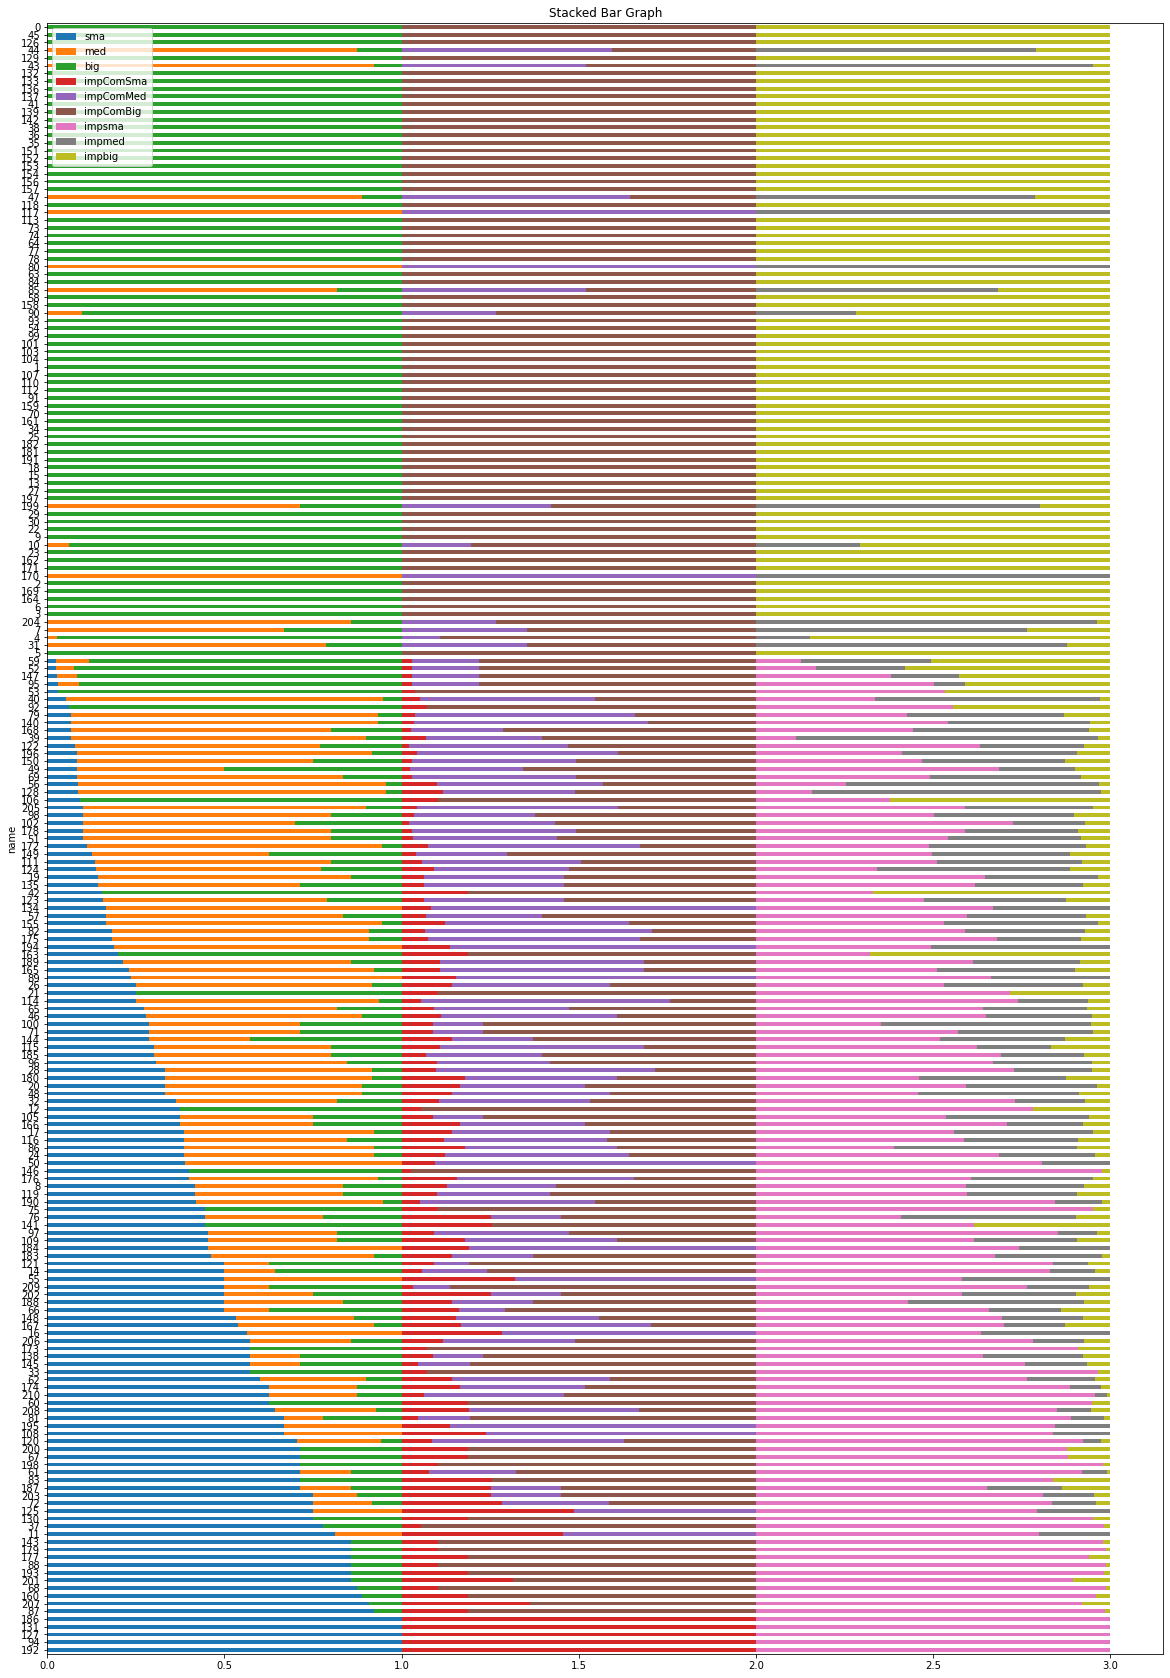

In [32]:
 #plot a Stacked Bar Graph

plt.figure(figsize=(20,30))
a.plot(
    x = "name",
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    mark_right = True, figsize=(20,30))
plt.show()

In [33]:
test = bip_network.vs.select(typen=0)

for user_ in test: # Loop over users in bipartite network
    # Find their node in user_network
    node_user_net = user_network.vs.find(name=user_["name"])
    user_["cluster"] = node_user_net["cluster"]
    user_["tipoC"] = node_user_net["tipoCom"]

list(bip_network.vs())


[igraph.Vertex(<igraph.Graph object at 0x7f7aa3cb4d50>, 0, {'name': 101, 'typen': 0, 'cluster': 0, 'tipoC': 0}),
 igraph.Vertex(<igraph.Graph object at 0x7f7aa3cb4d50>, 1, {'name': 202, 'typen': 1, 'cluster': None, 'tipoC': None}),
 igraph.Vertex(<igraph.Graph object at 0x7f7aa3cb4d50>, 2, {'name': 2101, 'typen': 0, 'cluster': 0, 'tipoC': 0}),
 igraph.Vertex(<igraph.Graph object at 0x7f7aa3cb4d50>, 3, {'name': 2202, 'typen': 1, 'cluster': None, 'tipoC': None}),
 igraph.Vertex(<igraph.Graph object at 0x7f7aa3cb4d50>, 4, {'name': 3101, 'typen': 0, 'cluster': 1, 'tipoC': 0}),
 igraph.Vertex(<igraph.Graph object at 0x7f7aa3cb4d50>, 5, {'name': 3202, 'typen': 1, 'cluster': None, 'tipoC': None}),
 igraph.Vertex(<igraph.Graph object at 0x7f7aa3cb4d50>, 6, {'name': 7101, 'typen': 0, 'cluster': 0, 'tipoC': 0}),
 igraph.Vertex(<igraph.Graph object at 0x7f7aa3cb4d50>, 7, {'name': 7202, 'typen': 1, 'cluster': None, 'tipoC': None}),
 igraph.Vertex(<igraph.Graph object at 0x7f7aa3cb4d50>, 8, {'name'

In [70]:
# Export Bip network with clusters id
ig.write(bip_network, "bip_with_dataHC.graphml")

In [34]:
bip_network.vs.attributes()

['name', 'typen', 'cluster', 'tipoC']

In [77]:
user_attrs

Index(['MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME',
       'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE'],
      dtype='object')

In [35]:
user_attr

['role', 'specialty', 'team', 'uward', 'agentfor']

In [36]:
copy_bip = bip_network.copy()
test = copy_bip.vs.select(typen=0)

for user_ in test: # Loop over users in bipartite network
    # Find their node in user_network
    #node_user_net = user_network.vs.find(name=user_["name"])
    data_user = user_dict[user_["name"]]
    user_[user_attr[0]] = data_user[0]
    user_[user_attr[1]] = data_user[1]
    user_[user_attr[2]] = data_user[2]
    user_[user_attr[3]] = data_user[3]
    user_[user_attr[4]] = data_user[4]
    #user_["cluster"] = node_user_net["cluster"]
    #user_["tipoC"] = node_user_net["tipoCom"]

list(copy_bip.vs())


[igraph.Vertex(<igraph.Graph object at 0x7f7aa3792e50>, 0, {'name': 101, 'typen': 0, 'cluster': 0, 'tipoC': 0, 'role': 10, 'specialty': 111, 'team': 1111, 'uward': 11211, 'agentfor': 111211}),
 igraph.Vertex(<igraph.Graph object at 0x7f7aa3792e50>, 1, {'name': 202, 'typen': 1, 'cluster': None, 'tipoC': None, 'role': None, 'specialty': None, 'team': None, 'uward': None, 'agentfor': None}),
 igraph.Vertex(<igraph.Graph object at 0x7f7aa3792e50>, 2, {'name': 2101, 'typen': 0, 'cluster': 0, 'tipoC': 0, 'role': 11, 'specialty': 111, 'team': 1111, 'uward': 11111, 'agentfor': 111011}),
 igraph.Vertex(<igraph.Graph object at 0x7f7aa3792e50>, 3, {'name': 2202, 'typen': 1, 'cluster': None, 'tipoC': None, 'role': None, 'specialty': None, 'team': None, 'uward': None, 'agentfor': None}),
 igraph.Vertex(<igraph.Graph object at 0x7f7aa3792e50>, 4, {'name': 3101, 'typen': 0, 'cluster': 1, 'tipoC': 0, 'role': 10, 'specialty': 113, 'team': 1121, 'uward': 11011, 'agentfor': 111111}),
 igraph.Vertex(<igra

In [38]:
# Export Bip network with clusters id
ig.write(copy_bip, "bip_with_attrsHC.graphml")